In [30]:
from cluster import cluster as cl
rc = cl.start_cluster('lobster', 14)

In [31]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [32]:
dv = rc[:]

In [33]:
%%px --local
maxorbs = 1.e9

import numpy as np
import rebound
import random
import os
import time

a1 = 0.05 # semimajor axis of innermost planet in AU

mp = 5*3.e-6 # 5 earth masses
gamma = (2./3.*mp)**(1./3.) # Hill radius with factor of a taken out
imax = 1.*np.pi/180. # maximum inclination (uniform distribution)
emax = 2.e-2 # maximum eccentricity (uniform distribution)
betamin = 5.
betamax = 10.

In [34]:
%%px --local
def longintegration(sim_id):
    random.seed(sim_id)
    
    beta1 = random.uniform(betamin, betamax)
    a2 = a1 + beta1*gamma*a1
    beta2 = random.uniform(betamin, betamax)
    a3 = a2 + beta2*gamma*a2
    
    sim = rebound.Simulation()
    sim.integrator="whfast"
    sim.ri_whfast.safe_mode = 0
    sim.G = 4*np.pi**2
    sim.exit_min_distance = a1*gamma # use smaller hill radius as exit condition
    
    
    sim.add(m=1.)
    sim.add(m=mp, a=a1, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.add(m=mp, a=a2, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.add(m=mp, a=a3, e=random.random()*emax, pomega=random.random()*2.*np.pi, inc=random.random()*imax, Omega=random.random()*2.*np.pi, f=random.random()*2.*np.pi)
    sim.move_to_com()
    ps = sim.particles
    
    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    sim.dt = P0*0.09
    
    features = [maxorbs, mp, gamma]
    for p in ps[1:sim.N_real]:
        features = features + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f, p.x, p.y, p.z, p.vx, p.vy, p.vz]
        
    E0 = sim.calculate_energy()
    t0 = time.time()
    
    start = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/start'+str(sim_id)+'.bin'
    sim.save(start)
    
    stable = [True] # assume it's stable and update if not
    try:
        sim.integrate(tmax)
    except:
        stable = [False]
            
    features = stable+[sim.t/P0]+features+[np.abs((sim.calculate_energy()-E0)/E0), time.time()-t0]
    fname = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/longintegrations'+str(os.getpid())+'.csv'
    with open(fname, 'a') as f:
        f.write(str(sim_id))
        for feature in features:
            f.write(',{0}'.format(feature))
        f.write('\n')
    
    end = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/end'+str(sim_id)+'.bin'
    sim.save(end)
    return features

In [43]:
Nsystems=2000
res = dv.map_async(longintegration, list(range(Nsystems)))

In [45]:
res.ready()

True

In [46]:
import pandas as pd
import numpy as np
import os

columns = ['Sim_ID', 'Stable', 'Norbits_instability', 'Norbits', 'Mplanet', 'RH/a']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i, 'x'+i, 'y'+i, 'z'+i, 'vx'+i, 'vy'+i, 'vz'+i]
columns += ['Rel_Eerr', 'integ_time']

frames = []
path = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/'
for f in os.listdir(path):
        if f.startswith('longintegrations'):
            frames.append(pd.read_csv(path+f, names=columns, index_col=0))
           
df = pd.concat(frames)
df = df.sort_index()
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
1995,True,1000000.0,1000000.0,0.000015,0.021544,0.05,0.01118,0.016562,-2.327501,0.010926,...,-0.849203,-2.844867,-0.071883,0.005552,-0.000415,-1.706854,-23.200242,-0.136886,1.723517e-06,12.726603
1996,True,1000000.0,1000000.0,0.000015,0.021544,0.05,0.01118,0.015123,3.523821,0.005280,...,1.060472,-4.657275,0.040300,-0.058823,-0.000453,19.562771,13.063685,-0.075824,2.556528e-07,13.009064
1997,True,1000000.0,1000000.0,0.000015,0.021544,0.05,0.01118,0.004423,4.201305,0.006816,...,-0.803942,1.460927,-0.048025,-0.052651,-0.000126,17.379992,-15.872978,0.002668,6.337741e-07,12.430386
1998,True,1000000.0,1000000.0,0.000015,0.021544,0.05,0.01118,0.014857,0.628871,0.013833,...,-2.806279,2.300246,-0.049105,-0.051912,0.000016,17.004898,-16.181680,0.009885,4.564044e-07,18.522982
1999,True,1000000.0,1000000.0,0.000015,0.021544,0.05,0.01118,0.011327,-0.485820,0.010869,...,-1.827689,-3.987138,-0.071628,-0.005607,-0.000333,1.604205,-23.290131,0.036602,7.648660e-08,12.731030


In [ ]:
df.to_csv(path+'dataset.csv', encoding='ascii')

In [36]:
import pandas as pd
path = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/'

columns = ['Sim_ID', 'Stable', 'Norbits_instability', 'Norbits', 'Mplanet', 'RH/a']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i, 'x'+i, 'y'+i, 'z'+i, 'vx'+i, 'vy'+i, 'vz'+i]
columns += ['Rel_Eerr', 'integ_time']

df = pd.read_csv(path+'dataset.csv', names=columns, index_col=0)

In [37]:
def HillSep(system):
    return (system['a2']-system['a1'])/(system['a1']*system['RH/a'])
df['HillSep'] = df.apply(HillSep, axis=1)

In [38]:
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time,HillSep
Sim_ID,,,,,,,,,,,,,,,,,,,,,
0,True,100000.000000,100000.0,0.000015,0.021544,0.05,0.01118,1.439839e-16,3.141593,0.0,...,1.570796,0.065065,1.175494e-38,0.0,-6.018531e-36,24.632345,0.0,9.269241e-09,28.965282,6.533266
1,False,9361.089309,100000.0,0.000015,0.021544,0.05,0.01118,1.439839e-16,3.141593,0.0,...,1.570796,0.059935,1.175494e-38,0.0,0.000000e+00,25.664856,0.0,1.548995e-06,2.742903,4.403093
2,True,100000.000000,100000.0,0.000015,0.021544,0.05,0.01118,1.439839e-16,3.141593,0.0,...,0.000000,0.065891,1.175494e-38,0.0,-6.018531e-36,24.477555,0.0,9.376660e-09,29.362431,6.868103
3,False,4732.554705,100000.0,0.000015,0.021544,0.05,0.01118,1.439839e-16,3.141593,0.0,...,0.000000,0.060671,0.000000e+00,0.0,-6.018531e-36,25.508848,0.0,5.750300e-07,1.373941,4.713894
4,False,2532.952502,100000.0,0.000015,0.021544,0.05,0.01118,1.439839e-16,3.141593,0.0,...,1.570796,0.060657,1.175494e-38,0.0,-1.203706e-35,25.511717,0.0,7.586806e-06,0.735631,4.708144


In [39]:
beta = df['HillSep'].values
tinstability = df['Norbits_instability'].values

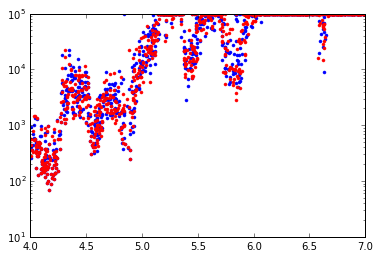

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(beta, tinstability, '.')
ax.plot(beta, offsettimes/df['P1'][0], 'r.')
ax.set_yscale('log')

(0.001, 15)

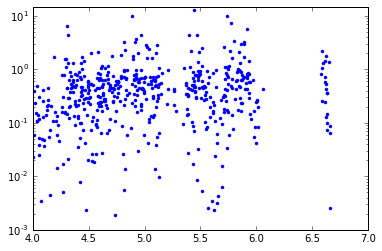

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(beta, np.abs(tinstability-offsettimes/df['P1'][0])/tinstability, '.')
ax.set_yscale('log')
ax.set_ylim([1.e-3,15])

In [47]:
diff = np.abs(tinstability-offsettimes/df['P1'][0])/tinstability
diff[-30:]

array([  0.00000000e+00,   7.55498540e-01,   0.00000000e+00,
         4.13921350e-01,   0.00000000e+00,   7.88115321e-01,
         0.00000000e+00,   1.69243505e+00,   0.00000000e+00,
         1.13021792e+00,   1.64280600e-01,   0.00000000e+00,
         1.18216514e+00,   0.00000000e+00,   0.00000000e+00,
         5.81461833e-01,   1.33641640e+00,   0.00000000e+00,
         0.00000000e+00,   1.30180305e+00,   0.00000000e+00,
         4.70778328e-01,   0.00000000e+00,   3.35430096e-12,
         0.00000000e+00,   1.84206633e-02,   0.00000000e+00,
         4.40671789e+00,   1.99029571e-02,   0.00000000e+00])

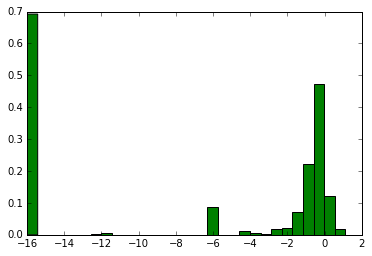

In [50]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(diff+1.e-16), 30, normed=1, facecolor='green')

In [24]:
%%px --local
def systemnooutput(sim_id):
    random.seed(sim_id)
    
    beta1 = random.uniform(betamin, betamax)
    a2 = a1 + beta1*gamma*a1
    a3 = a2 + beta1*gamma*a2
    
    sim = rebound.Simulation()
    sim.integrator="whfast"
    sim.G = 4*np.pi**2
    sim.exit_min_distance = a1*gamma # use smaller hill radius as exit condition
    
    
    sim.add(m=1.)
    sim.add(m=mp, a=a1, f=0.)
    sim.add(m=mp, a=a2, f=np.pi)
    sim.add(m=mp, a=a3, f=0.)
    sim.move_to_com()
    ps = sim.particles
    
    sim.init_megno()
    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    sim.dt = P0/100.
    
    features = [maxorbs, mp, gamma]
    for p in ps[1:sim.N_real]:
        features = features + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f, p.x, p.y, p.z, p.vx, p.vy, p.vz]
        
    stable = [True] # assume it's stable and update if not
    
    E0 = sim.calculate_energy()
    t0 = time.time()
    
    try:
        sim.integrate(tmax)
    except rebound.Encounter as error:
        stable = [False]

    filename = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/offsetfinalstate'+str(sim_id)+'.csv'
    with open(filename, 'w') as f:
        f.write(str(sim.t)) # this block added after the 1e7 dataset was generated for future use
        try:
            outs = [1./sim.calculate_lyapunov()]
        except: 
            outs = [np.inf]
        for p in ps[1:sim.N_real]:
            outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]
        for out in outs:
            f.write(',{0}'.format(out))
        f.write('\n')
    
    end = '/mnt/raid-cita/dtamayo/Stability/data/longintegrations/endoffset'+str(sim_id)+'.bin'
    sim.save(end)
    features = stable+[sim.t/P0]+features+[np.abs((sim.calculate_energy()-E0)/E0), time.time()-t0]
    return features

In [25]:
Nsystems=1000
res = dv.map(systemnooutput, list(range(Nsystems)))

In [30]:
sim_id = 3
df = pd.read_csv('/mnt/raid-cita/dtamayo/Stability/data/longintegrations/offsetfinalstate'+str(sim_id)+'.csv', names=columns)    

In [33]:
type(df['Time'][0])

numpy.float64

In [34]:
import numpy as np
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

offsettimes = np.zeros(1000)
for i, sim_id in enumerate(range(1000)):
    df = pd.read_csv('/mnt/raid-cita/dtamayo/Stability/data/longintegrations/offsetfinalstate'+str(sim_id)+'.csv', names=columns)
    offsettimes[i] = df['Time'][0]

In [35]:
offsettimes

array([  1.11802560e+03,   9.04410042e+01,   1.11802560e+03,
         9.34597851e+01,   3.90490567e+01,   1.11478892e+02,
         1.11802560e+03,   5.99506571e+01,   2.71548295e+01,
         1.41438512e+02,   1.11802560e+03,   1.11802560e+03,
         1.49142268e+02,   2.11244230e+01,   5.72412339e+01,
         1.11802560e+03,   2.22913845e+02,   1.11802560e+03,
         3.37677273e+00,   1.11802560e+03,   1.11802560e+03,
         3.33727289e+01,   1.11802560e+03,   1.11802560e+03,
         1.11802560e+03,   3.72869700e+02,   1.11802560e+03,
         9.52269029e+02,   4.05939444e+01,   1.11802560e+03,
         8.46274723e+02,   1.65610897e+01,   2.95292922e+00,
         9.86549259e+02,   1.11802560e+03,   1.11802560e+03,
         4.16199118e+02,   1.11802560e+03,   3.50563748e+02,
         1.04123961e+01,   3.60389404e+02,   1.11802560e+03,
         2.10172602e+02,   1.66339849e+00,   1.11802560e+03,
         2.06819084e+01,   1.11515686e+03,   3.80412907e+02,
         1.11802560e+03,

In [106]:
df = pd.read_csv('/mnt/raid-cita/dtamayo/Stability/data/longintegrations/output'+str(sim_id)+'.csv', names=columns)

In [107]:
df.tail()

,Time,Lyapunov Time,a1,P1,e1,pomega1,inc1,Omega1,f1,a2,...,inc2,Omega2,f2,a3,P3,e3,pomega3,inc3,Omega3,f3
90,100.723027,1.154399,0.049180,0.010906,0.044803,0.177510,0.0,0.0,2.389361,0.055573,...,0.0,0.0,-2.916349,0.060156,0.014754,0.028522,-2.689853,0.0,0.0,5.192771
91,101.842172,1.159185,0.049065,0.010868,0.045786,0.056406,0.0,0.0,-2.641276,0.055761,...,0.0,0.0,-4.126692,0.060099,0.014733,0.013196,-2.947203,0.0,0.0,4.927828
92,102.961317,1.163417,0.048830,0.010790,0.052561,0.482633,0.0,0.0,2.352726,0.055991,...,0.0,0.0,-4.060254,0.060190,0.014766,0.028714,-2.157541,0.0,0.0,4.495263
93,104.080462,1.167073,0.048843,0.010795,0.053450,1.170652,0.0,0.0,-2.311024,0.055886,...,0.0,0.0,-0.985280,0.060289,0.014803,0.032508,-2.524920,0.0,0.0,3.583646
94,104.659375,1.168710,0.047980,0.010510,0.071339,1.459649,0.0,0.0,-2.932587,0.057421,...,0.0,0.0,2.514817,0.060005,0.014698,0.038013,-2.821482,0.0,0.0,4.201389


In [28]:
cl.shutdown_cluster('lobster', rc)